In [1]:
import torch

class Operator:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Applies operator using PyTorch autograd wrapper"""
        return OperatorFunction.apply(self, x)

    def __matmul__(self, x: torch.Tensor) -> torch.Tensor:
        """Matrix-vector multiplication"""
        return self.__call__(x)

    def T(self, y: torch.Tensor) -> torch.Tensor:
        """Transpose operator (adjoint)"""
        device = y.device
        # Apply adjoint to the batch
        return self._adjoint(y).to(device).requires_grad_(True)

    def _matvec(self, x: torch.Tensor) -> torch.Tensor:
        """Apply the operator to a single (c, h, w) tensor"""
        raise NotImplementedError

    def _adjoint(self, y: torch.Tensor) -> torch.Tensor:
        """Apply the adjoint operator to a single (c, h, w) tensor"""
        raise NotImplementedError

In [2]:
#-----------------
# This is just for rendering on the website
import os
import sys
sys.path.append("..")
#-----------------

from IPPy import operators

class NegativeOperator(operators.Operator):
    def _matvec(self, x):
        """
        Since x is a standardized Tensor (i.e. its in the range [0, 1]), the negative image
        can be obtained by simply computing y = 1 - x.
        """
        return 1 - x
    
    def _adjoint(self, y):
        """
        The adjoint of the negative operator is again x = 1 - y.
        """
        return 1 - y

/Users/davideevangelista/computational-imaging/end-to-end/../IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(


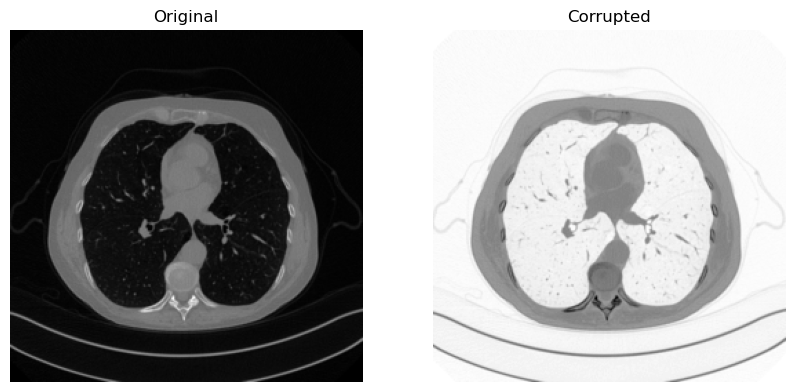

In [3]:
import glob

import torch
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x
    
# Get sample image
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x = test_data[0].unsqueeze(0)

# Define corruption operator
K = NegativeOperator()

# Compute negative of x
y = K(x)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(y.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')
plt.show()

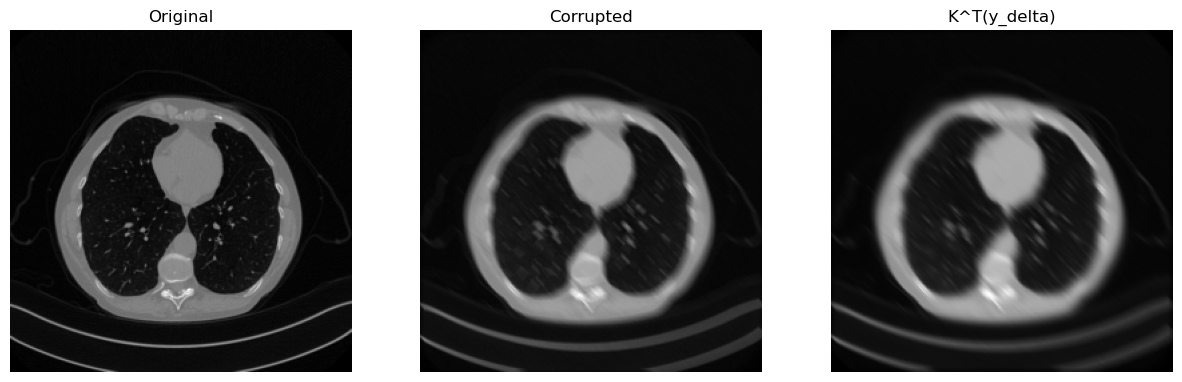

In [4]:
from IPPy import operators, utilities

# Get sample image from MayoDataset
x_true = test_data[10].unsqueeze(0)

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Compute (just for the sake of the explanation, the transpose)
x_T = K.T(y_delta)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_T.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('K^T(y_delta)')
plt.show()

In [5]:
# Define x_true and track its gradient
x_true = test_data[10].unsqueeze(0)
x_true.requires_grad_(True)

# Compute y_delta with no gradient tracking
with torch.no_grad():
    y = K(x_true)
    y_delta = y + utilities.gaussian_noise(y, noise_level=0.005)

# Example: compute f(x)
f = torch.sum(torch.square(K(x_true) - y_delta))

# Compute gradient
f.backward()
grad_x = x_true.grad
print(f"Grad_x = {torch.norm(grad_x).item():0.4f}")

Grad_x = 0.2143


Reconstruction SSIM: 0.9323.


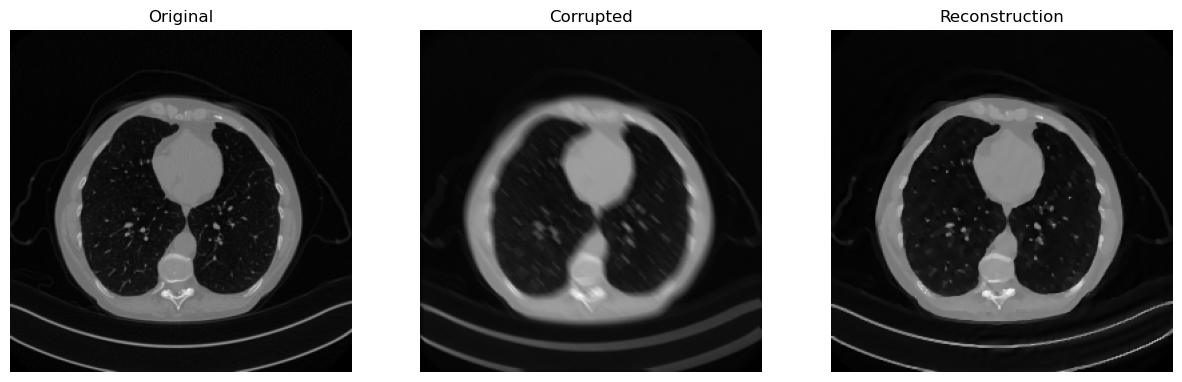

In [6]:
from IPPy import solvers, metrics

# Define the solver (e.g. ChambollePock)
solver = solvers.ChambollePockTpVUnconstrained(K) # -> takes as input the operator

# Compute solution
x_rec, _ = solver(y_delta, 
               lmbda=0.01, 
               x_true=x_true, 
               starting_point=torch.zeros_like(x_true),
               verbose=False,)

print(f"Reconstruction SSIM: {metrics.SSIM(x_rec, x_true):0.4f}.")
# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstruction')
plt.show()

In [7]:
from IPPy.nn import models

# Set device
device = utilities.get_device()

# Defining neural network architecture (IGNORE now)
model = models.UNet(ch_in=1, 
                    ch_out=1,
                    middle_ch=[64, 128, 256],
                    n_layers_per_block=2,
                    down_layers=("ResDownBlock", "ResDownBlock"),
                    up_layers=("ResUpBlock", "ResUpBlock"),
                    final_activation=None)

# Send model to device
model = model.to(device)

In [8]:
# Generate train and test data
train_data = MayoDataset(data_path="../data/Mayo/train", data_shape=256)
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [9]:
from torch import nn, optim

#--- Parameters
n_epochs = 0

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

# Cycle over the epochs
loss_total = torch.zeros((n_epochs,))
ssim_total = torch.zeros((n_epochs,))
for epoch in range(n_epochs):

    # Cycle over the batches
    epoch_loss = 0.0
    ssim_loss = 0.0
    for t, x in enumerate(train_loader):
        # Send x and y to device
        x = x.to(device)

        # Compute associated y_delta
        y = K(x)
        y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_pred = model(y_delta)
        loss = loss_fn(x_pred, x)
        loss.backward()
        optimizer.step()

        # update loss
        epoch_loss += loss.item()
        ssim_loss += metrics.SSIM(x_pred.cpu().detach(), x.cpu().detach())

        # Infos
        print(
            f"Epoch ({epoch+1} / {n_epochs}) -> Loss = {epoch_loss / (t + 1):0.4f}, "
            + f"SSIM = {ssim_loss / (t + 1):0.4f}.",
            end="\r",
        )

    # Update the history
    loss_total[epoch] = epoch_loss / (t + 1)
    ssim_total[epoch] = ssim_loss / (t + 1)

In [10]:
from IPPy.nn import trainer

# Save model state
trainer.save(model, weights_path="../weights/UNet")

In [11]:
# Load model
model = trainer.load(weights_path="../weights/UNet").to(device)

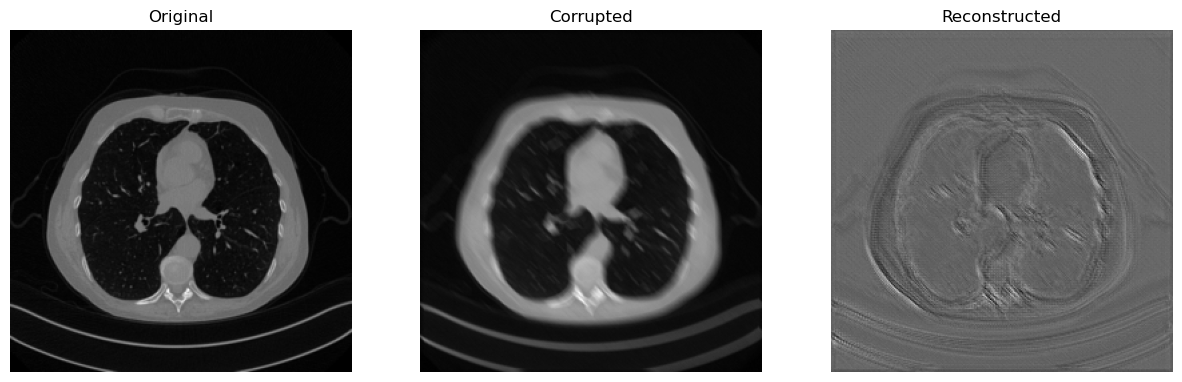

In [12]:
# Test on test data
for t, x_test in enumerate(test_loader):
    # Send to device
    x_test = x_test.to(device)

    # Compute y_delta
    y = K(x_test)
    y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

    # Predict with model (without computing the gradient to save memory)
    with torch.no_grad():
        x_pred = model(y_delta)
    
    # Visualize the input-output-prediction triplet
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(x_test[0].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1, 3, 2)
    plt.imshow(y_delta[0].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Corrupted')

    plt.subplot(1, 3, 3)
    plt.imshow(x_pred[0].cpu().detach().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed')
    plt.show()
    break